# Max Pressure traffic light control (SUMO + TraCI)

This notebook runs the **max pressure control** scenario only. Results are written to the **Network with max pressure control** folder.

## Algorithm Overview

Max Pressure is a mathematical control algorithm that:
1. Calculates the **pressure** on each approach: `Pressure = Incoming_Cars - Outgoing_Space`
2. Compares pressure across signal phases
3. Allocates green time to the phase with highest pressure
4. Operates without learning or complex state tracking

In [ ]:
import os
import sys
import time
import subprocess
import socket

# ==========================================
# 1. CONFIGURATION (MAX PRESSURE ONLY)
# ==========================================
BASE_DIR = os.getcwd()
SCENARIO_DIR = os.path.join(BASE_DIR, "Network with max pressure control")
RESULTS_DIR = os.path.join(SCENARIO_DIR, "results")
CONFIG_PATH = os.path.join(SCENARIO_DIR, "ff_heterogeneous.sumocfg")

if not os.path.exists(SCENARIO_DIR):
    # Create the directory structure if it doesn't exist
    print(f"Creating scenario folder: {SCENARIO_DIR}")
    os.makedirs(SCENARIO_DIR, exist_ok=True)
    # Copy network files from original network
    import shutil
    original_dir = os.path.join(BASE_DIR, "Original network")
    for file in ["ff_heterogeneous.sumocfg", "ff.net.xml", "ff_heterogeneous.rou.xml"]:
        src = os.path.join(original_dir, file)
        dst = os.path.join(SCENARIO_DIR, file)
        if os.path.exists(src):
            shutil.copy(src, dst)
            print(f"Copied {file}")

if not os.path.exists(RESULTS_DIR):
    print(f"Creating results folder: {RESULTS_DIR}")
    os.makedirs(RESULTS_DIR, exist_ok=True)

if not os.path.exists(CONFIG_PATH):
    sys.exit(f"Config file not found: {CONFIG_PATH}")

# SUMO tools
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("Please declare environment variable 'SUMO_HOME'")

import traci

# SUMO binary resolution (prefer SUMO_HOME/bin) - GUI
sumoBinary = "sumo-gui"
if 'SUMO_HOME' in os.environ:
    candidate = os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo-gui.exe')
    if os.path.exists(candidate):
        sumoBinary = candidate
    else:
        candidate = os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo-gui')
        if os.path.exists(candidate):
            sumoBinary = candidate

if not os.path.exists(sumoBinary):
    try:
# Logs (absolute paths) - save in results folder
sumo_log = os.path.join(RESULTS_DIR, "sumo_log.txt")
sumo_err = os.path.join(RESULTS_DIR, "sumo_err.txt")
traci_stdout = os.path.join(RESULTS_DIR, "traci_stdout.txt")

# Output files - save in results folder
EDGE_DATA_PATH = os.path.join(RESULTS_DIR, "edge_data.xml")
# Logs (absolute paths)
sumo_log = os.path.join(SCENARIO_DIR, "sumo_log.txt")
sumo_err = os.path.join(SCENARIO_DIR, "sumo_err.txt")
traci_stdout = os.path.join(SCENARIO_DIR, "traci_stdout.txt")

# Output files
EDGE_DATA_PATH = os.path.join(SCENARIO_DIR, "edge_data.xml")


def get_free_port():
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind(("localhost", 0))
        return s.getsockname()[1]


# Dynamic TraCI port
TRACI_PORT = get_free_port()
print(f"Using TraCI port: {TRACI_PORT}")
    "--tripinfo-output", os.path.join(RESULTS_DIR, "tripinfo.xml"),
    "--emission-output", os.path.join(RESULTS_DIR, "emissions.xml"),
sumoCmd = [
    sumoBinary,
    "-c", CONFIG_PATH,
    "--start",
    "--quit-on-end",
    "--tripinfo-output", os.path.join(SCENARIO_DIR, "tripinfo.xml"),
    "--emission-output", os.path.join(SCENARIO_DIR, "emissions.xml"),
    "--edgedata-output", EDGE_DATA_PATH,
    "--log", sumo_log,
    "--error-log", sumo_err,
    "--remote-port", str(TRACI_PORT)
]

TLS_IDS = ["E1", "E2", "E3", "E4"]

# Max Pressure parameters
MIN_GREEN = 5    # s (minimum green time before switch)
MAX_GREEN = 60   # s (maximum green time)


def start_sumo():
    log_handle = open(traci_stdout, "w", encoding="utf-8")
    proc = subprocess.Popen(
        sumoCmd,
        cwd=SCENARIO_DIR,
        stdout=log_handle,
        stderr=log_handle
    )
    return proc, log_handle


def connect_traci(proc, timeout_s=10):
    deadline = time.time() + timeout_s
    last_error = None
    while time.time() < deadline:
        if proc.poll() is not None:
            break
        try:
            return traci.connect(port=TRACI_PORT, host="localhost", numRetries=0, waitBetweenRetries=0)
        except Exception as e:
            last_error = e
            time.sleep(0.2)
    raise RuntimeError(f"Could not connect. Last error: {last_error}")


def get_phase_count(conn, tls_id):
    programs = conn.trafficlight.getCompleteRedYellowGreenDefinition(tls_id)
    if not programs:
        return 1
    return len(programs[0].phases)


def calculate_max_pressure(conn, tls_id):
    """
    Calculate the pressure for a traffic light.
    Pressure = Sum of incoming vehicles - Sum of outgoing available space
    
    Returns: dict with phase indices and their pressure scores
    """
    lanes_in = conn.trafficlight.getControlledLanes(tls_id)
    
    # Count incoming vehicles (halting = waiting in queue)
    incoming_queue = sum(conn.lane.getLastStepHaltingNumber(lane) for lane in lanes_in)
    
    # For a simple two-phase system, pressure indicates how congested incoming lanes are
    pressure = incoming_queue
    
    return pressure


def get_best_phase(conn, tls_id, phase_count):
    """
    Determine best phase based on max pressure principle.
    For a 4-phase traffic light with N-S and E-W movements:
    - Phase 0, 1: N-S green
    - Phase 2, 3: E-W green
    """
    # Get controlled lanes for this TLS
    lanes = conn.trafficlight.getControlledLanes(tls_id)
    
    # Identify approaching vs departing lanes
    # Incoming edges typically have suffixes like "_0", "_1" (lanes within edge)
    incoming_vehicles = sum(conn.lane.getLastStepHaltingNumber(lane) for lane in lanes)
    
    current_phase = conn.trafficlight.getPhase(tls_id)
    
    # Simple heuristic: if current phase has low queue, switch; else extend
    if incoming_vehicles > 5:  # High congestion on incoming
        return current_phase  # Keep current phase
    else:
        # Switch to next phase
        return (current_phase + 1) % phase_count


def run_max_pressure_control():
    proc = None
    log_handle = None
    conn = None
    try:
        proc, log_handle = start_sumo()
        conn = connect_traci(proc, timeout_s=10)

        # Ensure program 0 is active (base plan)
        for tls in TLS_IDS:
            conn.trafficlight.setProgram(tls, "0")

        phase_counts = {tls: get_phase_count(conn, tls) for tls in TLS_IDS}
        last_phase = {tls: conn.trafficlight.getPhase(tls) for tls in TLS_IDS}
        last_switch = {tls: conn.simulation.getTime() for tls in TLS_IDS}

        print("\n" + "="*70)
        print("MAX PRESSURE CONTROL SIMULATION STARTED")
        print("="*70)

        while conn.simulation.getTime() <= 3600:
            conn.simulationStep()
            sim_time = conn.simulation.getTime()

            for tls in TLS_IDS:
                current_phase = conn.trafficlight.getPhase(tls)
                if current_phase != last_phase[tls]:
                    last_phase[tls] = current_phase
                    last_switch[tls] = sim_time

                time_in_phase = sim_time - last_switch[tls]

                # Get pressure for current lanes
                pressure = calculate_max_pressure(conn, tls)

                # Decision logic: switch phase if minimum green time exceeded and pressure warrants
                if time_in_phase >= MIN_GREEN and pressure < 3:
                    # Low pressure: switch to next phase
                    next_phase = (current_phase + 1) % phase_counts[tls]
                    conn.trafficlight.setPhase(tls, next_phase)
                    last_phase[tls] = next_phase
                    last_switch[tls] = sim_time
                elif time_in_phase >= MAX_GREEN:
                    # Maximum green time reached: force switch
                    next_phase = (current_phase + 1) % phase_counts[tls]
                    conn.trafficlight.setPhase(tls, next_phase)
                    last_phase[tls] = next_phase
                    last_switch[tls] = sim_time

        if conn is not None:
            conn.close()
        if proc is not None:
            proc.wait(timeout=5)

        print("\n" + "="*70)
        print("SIMULATION COMPLETED SUCCESSFULLY")
        print("="*70 + "\n")

    finally:
        if conn is not None:
            try:
                conn.close()
            except Exception:
                pass
        if proc is not None and proc.poll() is None:
            proc.terminate()
        if log_handle:
            log_handle.close()


def print_logs():
    if os.path.exists(sumo_err):
        print("\n--- SUMO error log ---")
        with open(sumo_err, "r", encoding="utf-8", errors="ignore") as f:
            print(f.read()[:4000])
    else:
        print("\nSUMO error log not found.")

    if os.path.exists(sumo_log):
        print("\n--- SUMO log ---")
        with open(sumo_log, "r", encoding="utf-8", errors="ignore") as f:
            print(f.read()[:4000])
    else:
        print("\nSUMO log not found.")

    if os.path.exists(traci_stdout):
        print("\n--- SUMO stdout ---")
        with open(traci_stdout, "r", encoding="utf-8", errors="ignore") as f:
            print(f.read()[:4000])
    else:
        print("\nSUMO stdout not found.")


# ==========================================
# 2. EXECUTION

# ==========================================    print_logs()

try:    print(f"Error: {e}")

    run_max_pressure_control()    print("The simulation did not start.")
except Exception as e:

Using SUMO binary: C:\Program Files (x86)\Eclipse\Sumo\bin\sumo-gui.exe
Using TraCI port: 53927


C:\Users\antoi\AppData\Local\Temp\ipykernel_2168\2043020945.py:124: UserWarning: Call to deprecated function getAllProgramLogics, use getCompleteRedYellowGreenDefinition instead.
  programs = conn.trafficlight.getCompleteRedYellowGreenDefinition(tls_id)



MAX PRESSURE CONTROL SIMULATION STARTED

SIMULATION COMPLETED SUCCESSFULLY



## KPI summary for the max pressure scenario

This section reads the outputs stored in **Network with max pressure control** and reports key indicators plus visualizations.

Reading outputs from: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Network with max pressure control

KPI SUMMARY (MAX PRESSURE)
Avg. Travel Time: 365.27 s
Avg. Waiting Time: 186.37 s
Total Throughput: 7137 vehicles
----------------------------------------------------------------------
Total CO2 Emissions: 9230.68 kg
Total NOx: 3713520.25 g
Total Fuel: 2991753313.84 mg

EDGE SUMMARY (E0->E5 and E5->E0)

E0->E5
E0E1   | speed: 1.12 km/h | waiting: 85651.00 s | density: 137.34 veh/km
E1E2   | speed: 2.52 km/h | waiting: 71009.00 s | density: 133.49 veh/km
E2E3   | speed: 2.95 km/h | waiting: 63485.00 s | density: 126.10 veh/km
E3E4   | speed: 2.84 km/h | waiting: 56900.00 s | density: 105.19 veh/km
E4E5   | speed: 22.64 km/h | waiting: 2924.00 s | density: 9.22 veh/km

E5->E0
E5E4   | speed: 1.66 km/h | waiting: 83014.00 s | density: 134.99 veh/km
E4E3   | speed: 3.56 km/h | w

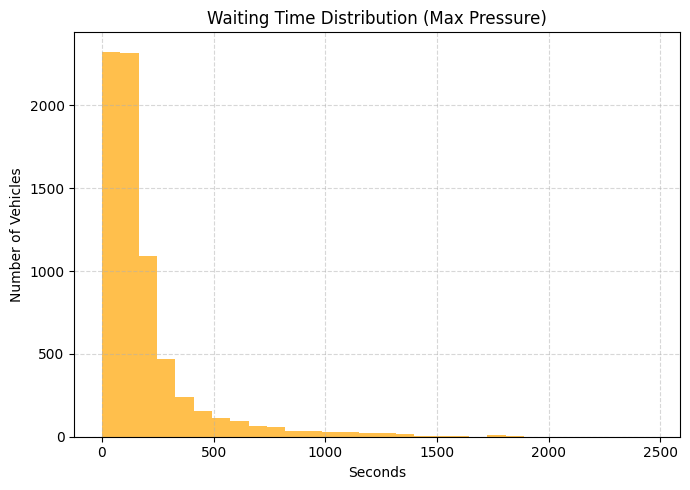


Saved plot to: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Network with max pressure control\max_pressure_waiting_time.png


In [ ]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# 1. HELPERS
# ==========================================
BASE_DIR = os.getcwd()
SCENARIO_DIR = os.path.join(BASE_DIR, "Network with max pressure control")
RESULTS_DIR = os.path.join(SCENARIO_DIR, "results")
EDGE_DATA_PATH = os.path.join(RESULTS_DIR, "edge_data.xml")

def parse_tripinfo(results_folder):
    path = os.path.join(results_folder, "tripinfo.xml")
    path = os.path.join(folder, "tripinfo.xml")
    tree = ET.parse(path)
    root = tree.getroot()
    trips = []
    for trip in root.findall('tripinfo'):
        trips.append({
            'id': trip.get('id'),
            'duration': float(trip.get('duration')),
            'waitingTime': float(trip.get('waitingTime')),
            'timeLoss': float(trip.get('timeLoss'))
        })
    return pd.DataFrame(trips)

def parse_emissions(results_folder):
    path = os.path.join(results_folder, "emissions.xml")
    path = os.path.join(folder, "emissions.xml")
    if not os.path.exists(path):
        return None
    tree = ET.parse(path)
    root = tree.getroot()
    total = {'CO2': 0, 'NOx': 0, 'fuel': 0}
    for timestep in root.findall('timestep'):
        for veh in timestep.findall('vehicle'):
            total['CO2'] += float(veh.get('CO2', 0))
            total['NOx'] += float(veh.get('NOx', 0))
            total['fuel'] += float(veh.get('fuel', 0))
    return total


def parse_edge_data(path):
    if not os.path.exists(path):
        return {}
    tree = ET.parse(path)
    root = tree.getroot()
    last_interval = root.findall('interval')[-1]
    edge_stats = {}
    for edge in last_interval.findall('edge'):
        e_id = edge.get('id')
        edge_stats[e_id] = {
            'speed': float(edge.get('speed')),
            'waiting': float(edge.get('waitingTime')),
            'density': float(edge.get('density'))
        }
    return edge_stats


# ==========================================
# 2. KPI SUMMARY
print(f"Reading outputs from: {RESULTS_DIR}")
print(f"Reading outputs from: {SCENARIO_DIR}")
df = parse_tripinfo(RESULTS_DIR)
emissions = parse_emissions(RESULTS_DIR)
emissions = parse_emissions(SCENARIO_DIR)
edge_stats = parse_edge_data(EDGE_DATA_PATH)

print("\n" + "=" * 70)
print("KPI SUMMARY (MAX PRESSURE)")
print("=" * 70)
print(f"Avg. Travel Time: {df['duration'].mean():.2f} s")
print(f"Avg. Waiting Time: {df['waitingTime'].mean():.2f} s")
print(f"Total Throughput: {len(df)} vehicles")

if emissions:
    print("-" * 70)
    print(f"Total CO2 Emissions: {emissions['CO2'] / 1000000:.2f} kg")
    print(f"Total NOx: {emissions['NOx']:.2f} g")
    print(f"Total Fuel: {emissions['fuel']:.2f} mg")

print("\n" + "=" * 70)
print("EDGE SUMMARY (E0->E5 and E5->E0)")
print("=" * 70)

edges_forward = ["E0E1", "E1E2", "E2E3", "E3E4", "E4E5"]
edges_backward = ["E5E4", "E4E3", "E3E2", "E2E1", "E1E0"]

for direction, edges in [("E0->E5", edges_forward), ("E5->E0", edges_backward)]:
    print(f"\n{direction}")
    for e in edges:
        stats = edge_stats.get(e, {'speed': 0, 'waiting': 0, 'density': 0})
        speed_kmh = stats['speed'] * 3.6  # Convert m/s to km/h
        print(f"{e:<6} | speed: {speed_kmh:.2f} km/h | waiting: {stats['waiting']:.2f} s | density: {stats['density']:.2f} veh/km")

# ==========================================
# 3. VISUALIZATION
# ==========================================
plt.figure(figsize=(7, 5))
plt.hist(df['waitingTime'], bins=30, alpha=0.7, color='orange')
plt.title('Waiting Time Distribution (Max Pressure)')
plt.xlabel('Seconds')
plt.ylabel('Number of Vehicles')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plot_path = os.path.join(RESULTS_DIR, "max_pressure_waiting_time.png")
plot_path = os.path.join(SCENARIO_DIR, "max_pressure_waiting_time.png")
plt.savefig(plot_path, dpi=300)
plt.show()
print(f"\nSaved plot to: {plot_path}")